In [2]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
import pickle
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

## Experiment 1 - Coupled Three Box

List of experiments:

a) Abrupt

b) High Emissions

c) Mid. Emissions

c) Overshoot

#### Setup and Run Experiments

In [3]:
# Required variables
t_end, t_star = 251, 50
t = np.arange(0,t_end)
n_boxes = 3

# Initialize forcing vectors and run scenarios
scenarios = ['Abrupt','High Emissions','Mid. Emissions','Overshoot']
forcings, full_outputs, T_out = {}, {}, {}
for i, scen in enumerate(scenarios):
  full_outputs[scen] = BudykoSellers.Run_Budyko_Sellers(scen_flag=i, n_boxes=n_boxes, diff_flag=1)
  forcings[scen] = np.tile(full_outputs[scen]['forcing_ts'], (n_boxes, 1))
  T_out[scen] = np.squeeze(full_outputs[scen]['T_ts'])[0:n_boxes,:]

/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:332: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


### Method 1: Pattern Scaling

In [109]:
operator_PS, T_pred_PS, error_metrics_PS = emulator_utils.emulate_scenarios('PS', scenarios=scenarios, outputs=T_out, forcings=forcings)
#emulator_utils.plot_true_pred(T_out, T_pred_PS, scenarios, operator='PS')
#emulator_utils.save_error(error_metrics_PS, 'exp1_1_PS_error')

Train: Abrupt - L2 Error
	Test: Abrupt - [24.00411614 10.14833691 12.04788585]
	Test: High Emissions - [101.30448921  25.19457861  22.78175407]
	Test: Mid. Emissions - [58.38963818 15.57487011 17.8231948 ]
	Test: Overshoot - [69.41935576 18.99940601 21.50678075]
Train: High Emissions - L2 Error
	Test: Abrupt - [47.71674579 21.33257192 20.58177135]
	Test: High Emissions - [1.22675989 0.30986338 0.32978779]
	Test: Mid. Emissions - [36.41097558 12.513508    7.33997215]
	Test: Overshoot - [50.53341055 18.17489108  9.84577934]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [36.40772112 14.84069956 18.08217784]
	Test: High Emissions - [34.08046091 10.65873108  4.38511775]
	Test: Mid. Emissions - [24.63066515  7.53918018  6.17233578]
	Test: Overshoot - [42.6633546  14.00596108  9.88172441]
Train: Overshoot - L2 Error
	Test: Abrupt - [36.57232157 14.14884831 19.35983054]
	Test: High Emissions - [33.5439999  11.95988142  2.11823938]
	Test: Mid. Emissions - [24.6342913   7.6372815   6.51063192

In [97]:
def plot_single_heatmap(error_metrics: dict,
                        method: str,
                        train_scenarios: list[str],
                        test_scenarios: list[str],
                        ax: plt.Axes,
                        vmax: float,
                        cmap: str = "Reds",
                        long_title: str = '',
                        add_xlabel: bool = True,
                        add_ylabel: bool = True,
                        add_cbar: bool = False) -> None:
    """
    Plots a single heatmap on a given matplotlib axis.
    The diagonal (train == test) is set to NaN.
    """
    # Build the matrix of *mean* errors
    data = np.empty((len(train_scenarios), len(test_scenarios)))

    for i, scen_train in enumerate(train_scenarios):
        for j, scen_test in enumerate(test_scenarios):
            # 1. SET DIAGONAL TO N/A
            if scen_train == scen_test:
                data[j, i] = np.nan
                continue
            
            # The original function had a special case for 'direct' which is now
            # covered by the diagonal check. We assume the general case here.
            try:
                # Assuming structure: error_metrics[method][exp][train][test]
                value = np.mean(error_metrics[method][scen_train][scen_test])
            except KeyError:
                # If a train/test combination doesn't exist, treat as NaN
                value = np.nan
            data[j, i] = value
    
    # Plot the heatmap using the provided axis and vmax
    sns.heatmap(
        data,
        ax=ax,
        cmap=cmap,
        vmin=0,
        vmax=vmax,
        linewidth=0.5,
        annot=True,
        fmt=".2g",
        cbar=add_cbar, # Colorbar is controlled by the parent function
        cbar_kws={"label": r"NRMSE [\%]"} if add_cbar else None
    )

    # Configure labels and title for the subplot
    ax.set_title(long_title)
    tick_labels = ['Abr.','Hi. Em.', 'Mid. Em.', 'Over.']

    if add_xlabel:
        #ax.set_xlabel("Train scenario", fontsize=24)
        ax.set_xticklabels(tick_labels, rotation=45, ha="right")
    else:
        # Hide x-axis labels if not needed (for top row plots)
        ax.set_xlabel("")
        ax.set_xticklabels([])

    if add_ylabel:
        #ax.set_ylabel("Test scenario", fontsize=24)
        ax.set_yticklabels(tick_labels, rotation=45)
    else:
        # Hide y-axis labels if not needed (for right column plots)
        ax.set_ylabel("")
        ax.set_yticklabels([])

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_error_heatmap(error_metrics: dict,
                       exp: str,
                       method: str,
                       train_scenarios: list[str],
                       test_scenarios:  list[str],
                       cmap: str = "Reds",
                       vmax: float | None = None,
                       ax: plt.Axes | None = None,
                       save: bool = False,
                       long_title: str = 'Method X: ??') -> plt.Axes:
    """
    Plot a single heat-map of mean error values for one experiment / method.

    Parameters
    ----------
    error_metrics : dict
        error_metrics[method][exp][train][test] -> 1-D array-like of errors
        If *method* == "direct", the structure is
        error_metrics["direct"][exp][scenario] -> 1-D array-like.
    exp : str
        Experiment name (e.g. "2box", "3box").
    method : str
        One method key to visualise.
    train_scenarios, test_scenarios : list[str]
        Scenario labels that define the y- and x-axes of the heat-map.
    cmap : str, optional
        Matplotlib/Seaborn colour-map.  Default "Reds".
    vmax : float, optional
        Upper limit of the colour-bar.  If None, it is chosen automatically.
    ax : matplotlib.axes.Axes, optional
        Axis to draw on.  If omitted a new figure/axis is created.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The axis containing the heat-map.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))

    # Build the matrix of *mean* errors
    data = np.empty((len(train_scenarios), len(test_scenarios)))

    for i, scen_train in enumerate(train_scenarios):
        for j, scen_test in enumerate(test_scenarios):
            if method == "direct":
                # 'direct' is only defined when train == test
                value = (np.mean(error_metrics["direct"][exp][scen_train])
                         if scen_train == scen_test else np.nan)
            else:
                # Average over the trailing dimension(s) (e.g., regions)
                value = np.mean(error_metrics[scen_train][scen_test])
            data[j, i] = value

    # Optionally cap the colour scale
    if vmax is None:
        vmax = np.nanmax(data)

    sns.heatmap(
        data,
        ax=ax,
        cmap=cmap,
        vmin=0,
        vmax=vmax,
        linewidth=0.5,
        annot=True,
        fmt=".2g",
        cbar_kws={"label": r"NRMSE [\%]"}
    )

    ax.set_xlabel("Train scenario",fontsize=24)
    ax.set_ylabel("Test scenario",fontsize=24)
    ax.set_xticklabels(['Abr.','Hi. Em.', 'Mid. Em.', 'Over.'], rotation=45, ha="right")
    ax.set_yticklabels(['Abr.','Hi. Em.', 'Mid. Em.', 'Over.'], rotation=45)
    ax.set_title(f'{long_title}')

    plt.tight_layout()

    if save:
        plt.savefig(f'Figures/error_{exp}_{method}.pdf',dpi=900)

    return ax


In [100]:
def plot_error_heatmap_grid(error_metrics: dict,
                            methods: list[str],
                            titles: list[str],
                            train_scenarios: list[str],
                            test_scenarios: list[str],
                            cmap: str = "Reds",
                            save: bool = False):
    """
    Creates a 2x2 grid of error heatmaps with a single, correctly positioned colorbar.
    """
    fig, axes = plt.subplots(2, 2, figsize=(11, 10), sharex='col')

    global_vmax = 0
    for method in methods:
        matrix = np.array([[
            np.mean(error_metrics[method].get(scen_train, {}).get(scen_test, np.nan))
            if scen_train != scen_test else np.nan
            for scen_test in test_scenarios
        ] for scen_train in train_scenarios])
        global_vmax = max(global_vmax, np.nanmax(matrix))
    global_vmax = 10

    mappable = None
    for i, ax in enumerate(axes.flat):
        # --- CHANGE 2: Ensure y-labels are added to the whole first column ---
        # This logic correctly adds labels to the left column (i=0, i=2)
        add_xlabel = (i >= 2)
        add_ylabel = (i % 2 == 0)

        plot_single_heatmap(
            error_metrics=error_metrics,
            method=methods[i],
            train_scenarios=train_scenarios,
            test_scenarios=test_scenarios,
            ax=ax,
            vmax=global_vmax,
            cmap=cmap,
            long_title=titles[i],
            add_xlabel=add_xlabel,
            add_ylabel=add_ylabel
        )
        if i == 0:
            mappable = ax.collections[0]

    fig.supxlabel("Train scenario", fontsize=24)
    fig.supylabel("Test scenario", fontsize=24)

    # --- CHANGE 1: Correctly position the colorbar ---
    # First, apply a tight layout to arrange the subplots
    fig.tight_layout()
    
    # Then, adjust the subplot arrangement to make space on the right for the colorbar
    fig.subplots_adjust(right=0.85)
    
    # Create a new, dedicated axis for the colorbar in the reserved space
    # The arguments are [left, bottom, width, height] in figure-relative coordinates
    cbar_ax = fig.add_axes([0.88, 0.13, 0.03, 0.817])
    
    # Add the colorbar to its dedicated axis
    cbar = fig.colorbar(mappable, cax=cbar_ax)
    cbar.set_label(r"NRMSE [\%]", size=14)
    cbar.outline.set_visible(False)
    
    if save:
        plt.savefig(f'Figures/error_grid_3box.pdf', dpi=900)

    plt.show()

In [113]:
error_metrics_all = {
  'PS':error_metrics_PS,
  'Deconv':error_metrics_deconvolve,
  'Fit':error_metrics_fit,
  'DMD':error_metrics_DMD
}

True
False
True
False


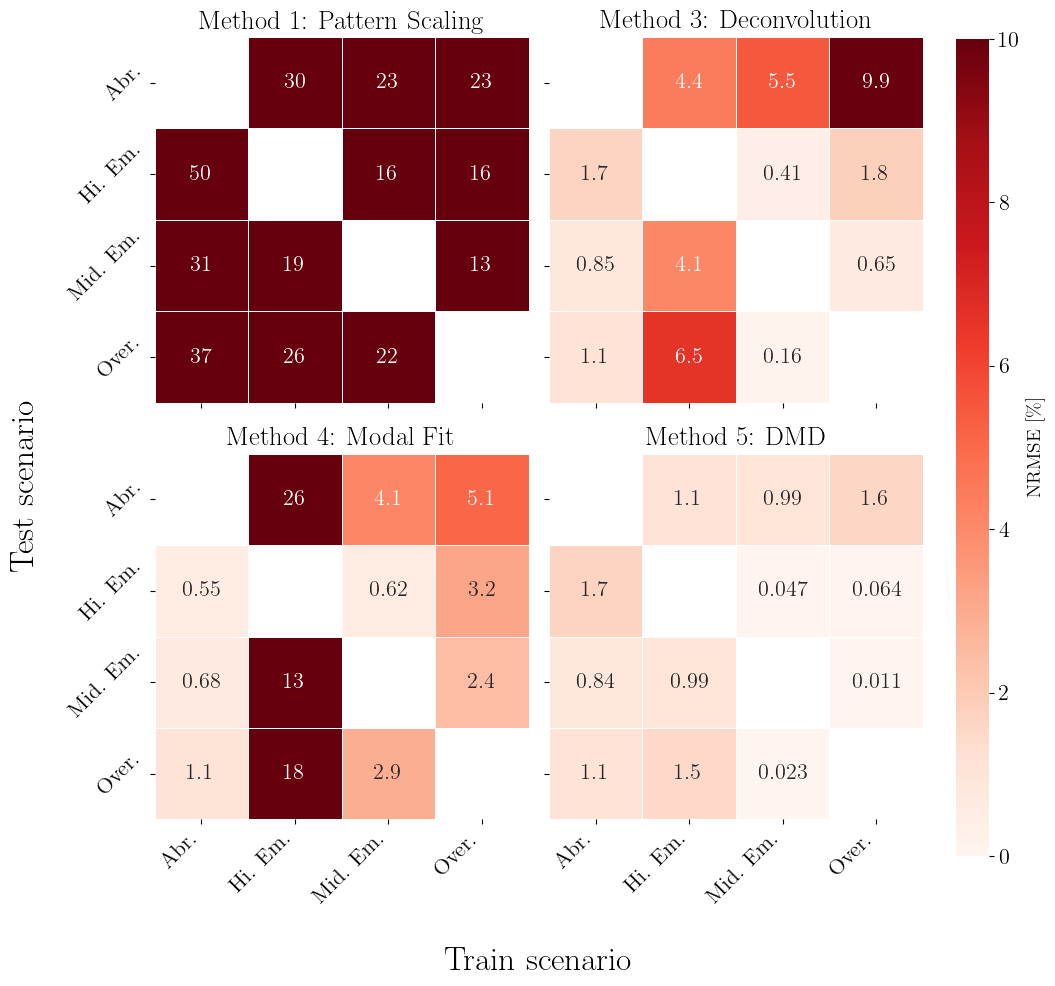

In [114]:
methods_to_plot = ["PS", "Deconv", "Fit", "DMD"]
titles_for_plots = ["Method 1: Pattern Scaling", "Method 3: Deconvolution", "Method 4: Modal Fit", "Method 5: DMD"]

plot_error_heatmap_grid(
    error_metrics=error_metrics_all,
    methods=methods_to_plot,
    titles=titles_for_plots,
    train_scenarios=scenarios,
    test_scenarios=scenarios,
    cmap="Reds",
    save=True
)

### Method 2: Fluctuation Dissipation Theorem

In [111]:
error_metrics_FDT

{'Abrupt': array([0.30077086, 0.42291033, 0.28745923]),
 'High Emissions': array([1.1766827 , 1.14776921, 1.16849642]),
 'Mid. Emissions': array([0.64374571, 0.51480659, 0.49450843]),
 'Overshoot': array([0.77623303, 1.19122537, 1.03976381])}

Train: Impulse Forcing - L2 Error


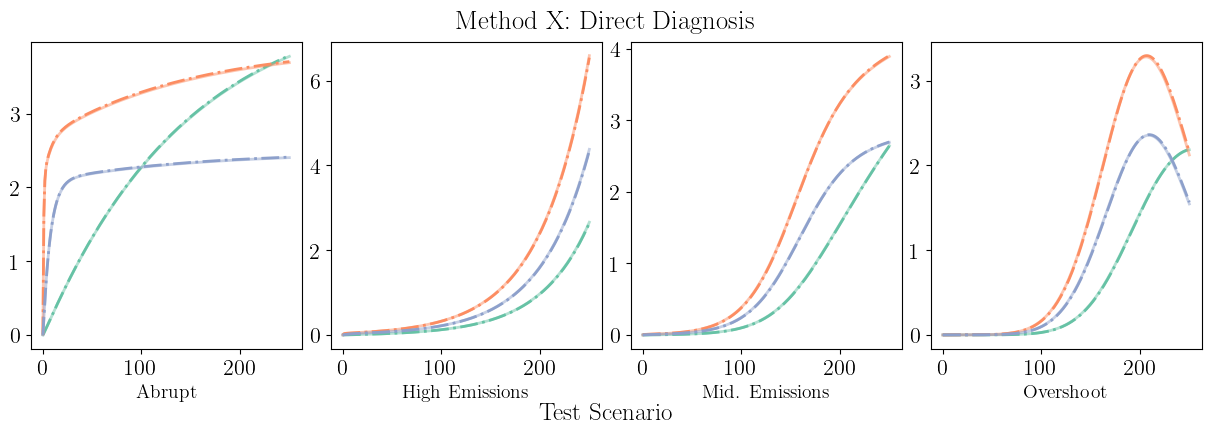

In [110]:
dt = 1
operator_FDT, T_pred_FDT, error_metrics_FDT = emulator_utils.emulate_scenarios('direct', scenarios=scenarios, outputs=T_out, forcings=forcings, n_boxes=n_boxes, dt=dt, diff_flag=1, delta=1)
emulator_utils.plot_true_pred_direct(T_out, T_pred_FDT, scenarios)
#emulator_utils.save_error(error_metrics_FDT, 'exp1_2_FDT_error')

### Method 5: Dynamic Mode Decomposition (DMD)

In [112]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_DMD, T_pred_DMD, error_metrics_DMD = emulator_utils.emulate_scenarios('DMD', scenarios=scenarios, outputs=T_out, forcings=forcings, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)
#emulator_utils.plot_true_pred(T_out, T_pred_DMD, scenarios)
#emulator_utils.save_error(error_metrics_DMD, 'exp1_5_DMD_error')

Train: Abrupt - L2 Error
	Test: Abrupt - [0.00195203 0.01604252 0.00443933]
	Test: High Emissions - [1.62239643 1.85677613 1.62642488]
	Test: Mid. Emissions - [1.02119895 0.77929208 0.70991784]
	Test: Overshoot - [1.08231883 1.16065488 1.04884698]
Train: High Emissions - L2 Error
	Test: Abrupt - [1.11236459 1.16427951 1.0393622 ]
	Test: High Emissions - [0.00013655 0.00062037 0.00017474]
	Test: Mid. Emissions - [0.73839694 1.17440281 1.04591076]
	Test: Overshoot - [1.03683032 1.85731121 1.64571842]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [0.35889437 1.86081327 0.75526844]
	Test: High Emissions - [0.02856673 0.07515641 0.03710753]
	Test: Mid. Emissions - [0.00683315 0.0157471  0.01050627]
	Test: Overshoot - [0.01366988 0.0289466  0.02581058]
Train: Overshoot - L2 Error
	Test: Abrupt - [0.3499018  3.50103696 0.86614965]
	Test: High Emissions - [0.0242007  0.13378039 0.03390878]
	Test: Mid. Emissions - [0.00332103 0.02272194 0.00569258]
	Test: Overshoot - [0.00034996 0.00055294 0

<Axes: title={'center': 'Method 6: DMD'}, xlabel='Train scenario', ylabel='Test scenario'>

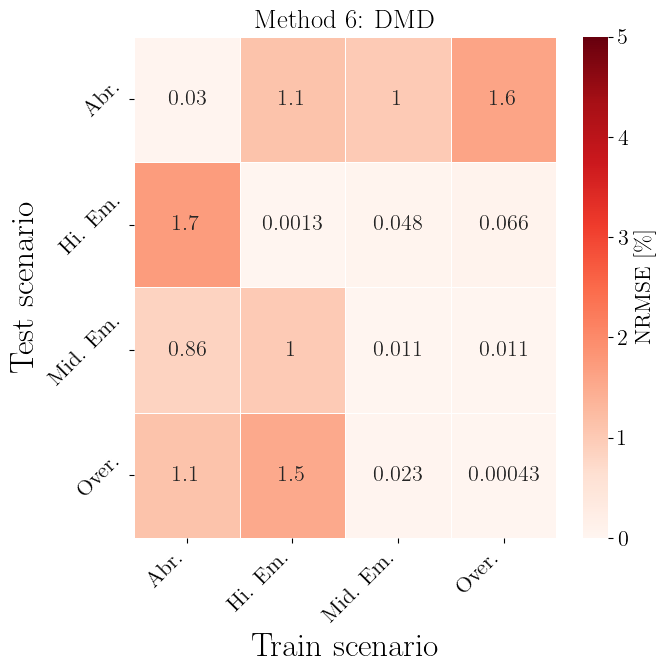

In [135]:
plot_error_heatmap(
    error_metrics   = error_metrics_DMD,
    exp             = "3box_coup",
    method          = "DMD",
    train_scenarios = scenarios,
    test_scenarios  = scenarios,
    vmax            = 5,
    save = True,
    long_title = 'Method 6: DMD'
)

### Method 6: EDMD

Train: Abrupt - L2 Error
	Test: Abrupt - [0.01411515 0.11245775 0.03193134]
	Test: High Emissions - [1.69468558 1.90812405 1.69473636]
	Test: Mid. Emissions - [1.07611365 0.80806719 0.74608034]
	Test: Overshoot - [1.14240959 1.19177959 1.09117541]
Train: High Emissions - L2 Error
	Test: Abrupt - [1.15693446 1.20301885 1.08339567]
	Test: High Emissions - [0.00099809 0.00439681 0.00127167]
	Test: Mid. Emissions - [0.76585386 1.20512289 1.08717717]
	Test: Overshoot - [1.07356938 1.90363974 1.70774114]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [0.36540574 1.90528808 0.76541857]
	Test: High Emissions - [0.02927111 0.07756085 0.03795411]
	Test: Mid. Emissions - [0.00714897 0.01616286 0.01088341]
	Test: Overshoot - [0.01422484 0.02935802 0.02664737]
Train: Overshoot - L2 Error
	Test: Abrupt - [0.35577186 3.72017009 0.88402659]
	Test: High Emissions - [0.02487544 0.14378837 0.03499499]
	Test: Mid. Emissions - [0.00340725 0.0242712  0.005833  ]
	Test: Overshoot - [0.00034082 0.00054131 0

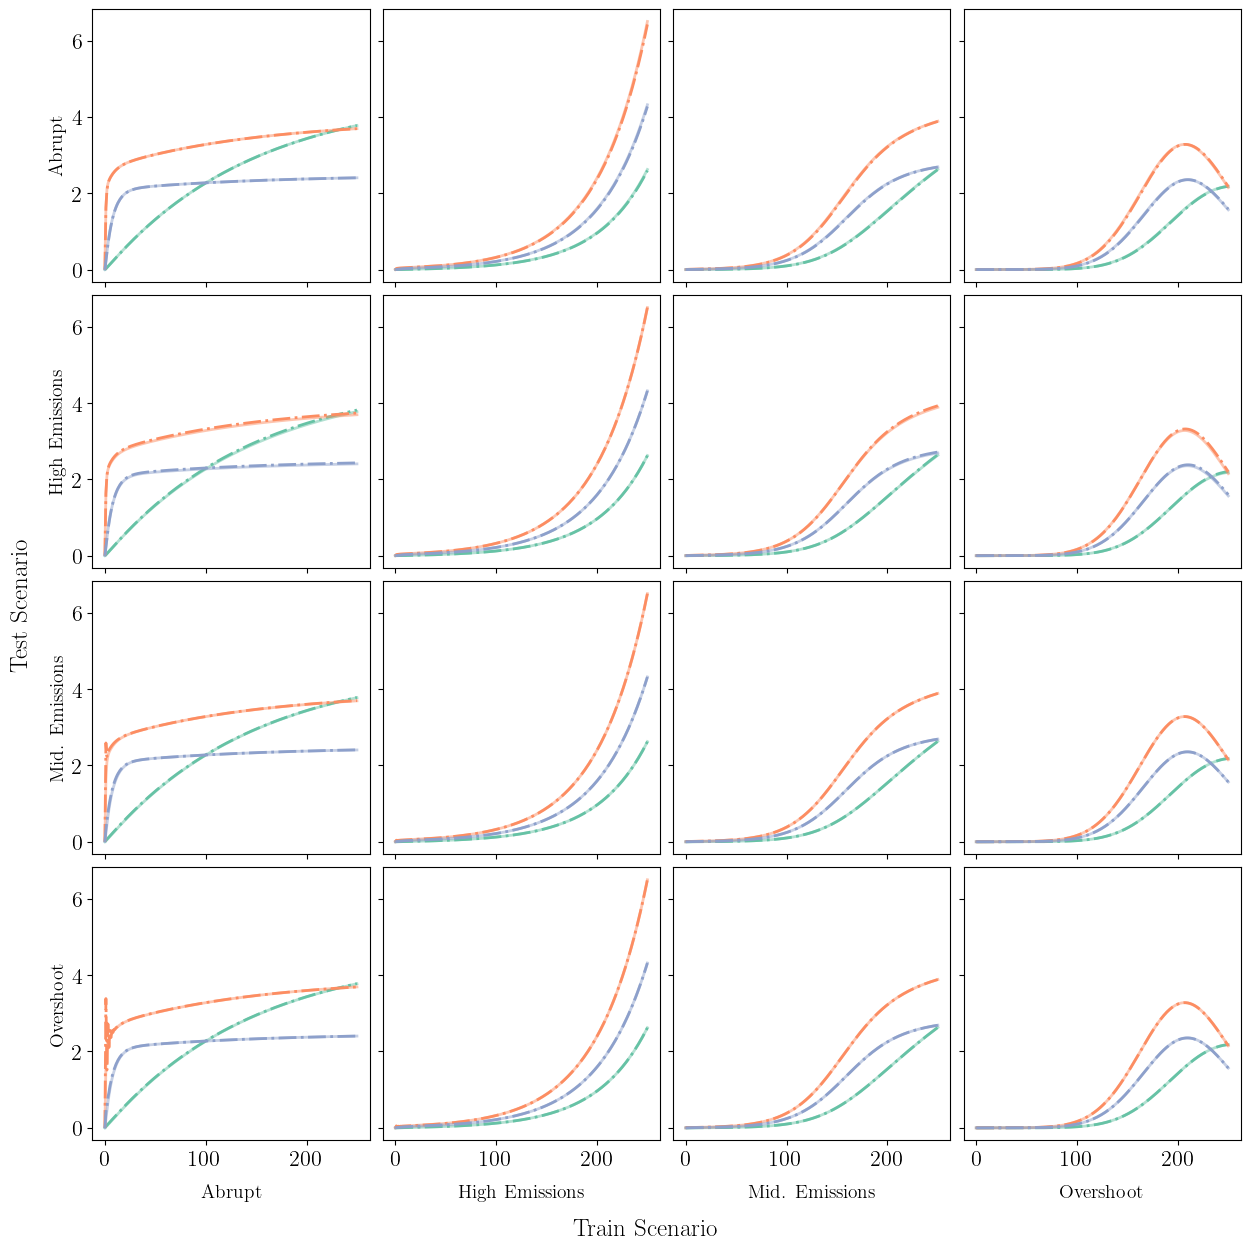

In [5]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
w_dict = emulator_utils.Vector_Dict(method='hermite', degree=1)
F_dict = emulator_utils.Vector_Dict(method='hermite', degree=1)
#w_dict = emulator_utils.Vector_Dict(method='deriv', degree=1)
#F_dict = emulator_utils.Vector_Dict(method='deriv', degree=1)
operator_EDMD, T_pred_EDMD, error_metrics_EDMD = emulator_utils.emulate_scenarios('EDMD', scenarios=scenarios, outputs=T_out, forcings=forcings, w0=w0, t=t, dt=dt,
                                                                n_steps=n_steps, n_boxes=n_boxes, w_dict=w_dict, F_dict=F_dict)
emulator_utils.plot_true_pred(T_out, T_pred_EDMD, scenarios)
emulator_utils.save_error(error_metrics_EDMD, 'exp1_6_EDMD_error')

### Method 3: Deconvolution

Train: Abrupt - L2 Error
	Test: Abrupt - [0.00985738 0.4749401  0.09437631]
	Test: High Emissions - [1.62265176 1.85310547 1.63085974]
	Test: Mid. Emissions - [1.03500986 0.78789513 0.72176529]
	Test: Overshoot - [1.10120422 1.164332   1.05776954]
Train: High Emissions - L2 Error
	Test: Abrupt - [0.36154732 8.36507475 4.56041557]
	Test: High Emissions - [0.0319553  0.20481687 0.09080327]
	Test: Mid. Emissions - [0.24839744 7.73694253 4.30526119]
	Test: Overshoot - [ 0.39166629 12.43533135  6.80042231]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [4.9476482  9.61549275 1.91556619]
	Test: High Emissions - [0.50656667 0.62141895 0.10687606]
	Test: Mid. Emissions - [0.00323602 0.01331581 0.00538825]
	Test: Overshoot - [0.10730653 0.31908146 0.03871838]
Train: Overshoot - L2 Error
	Test: Abrupt - [14.89034461 12.04871705  2.89516235]
	Test: High Emissions - [2.69366589 2.27480416 0.51644542]
	Test: Mid. Emissions - [1.1006566  0.71049253 0.13601208]
	Test: Overshoot - [0.07586902 0.3751

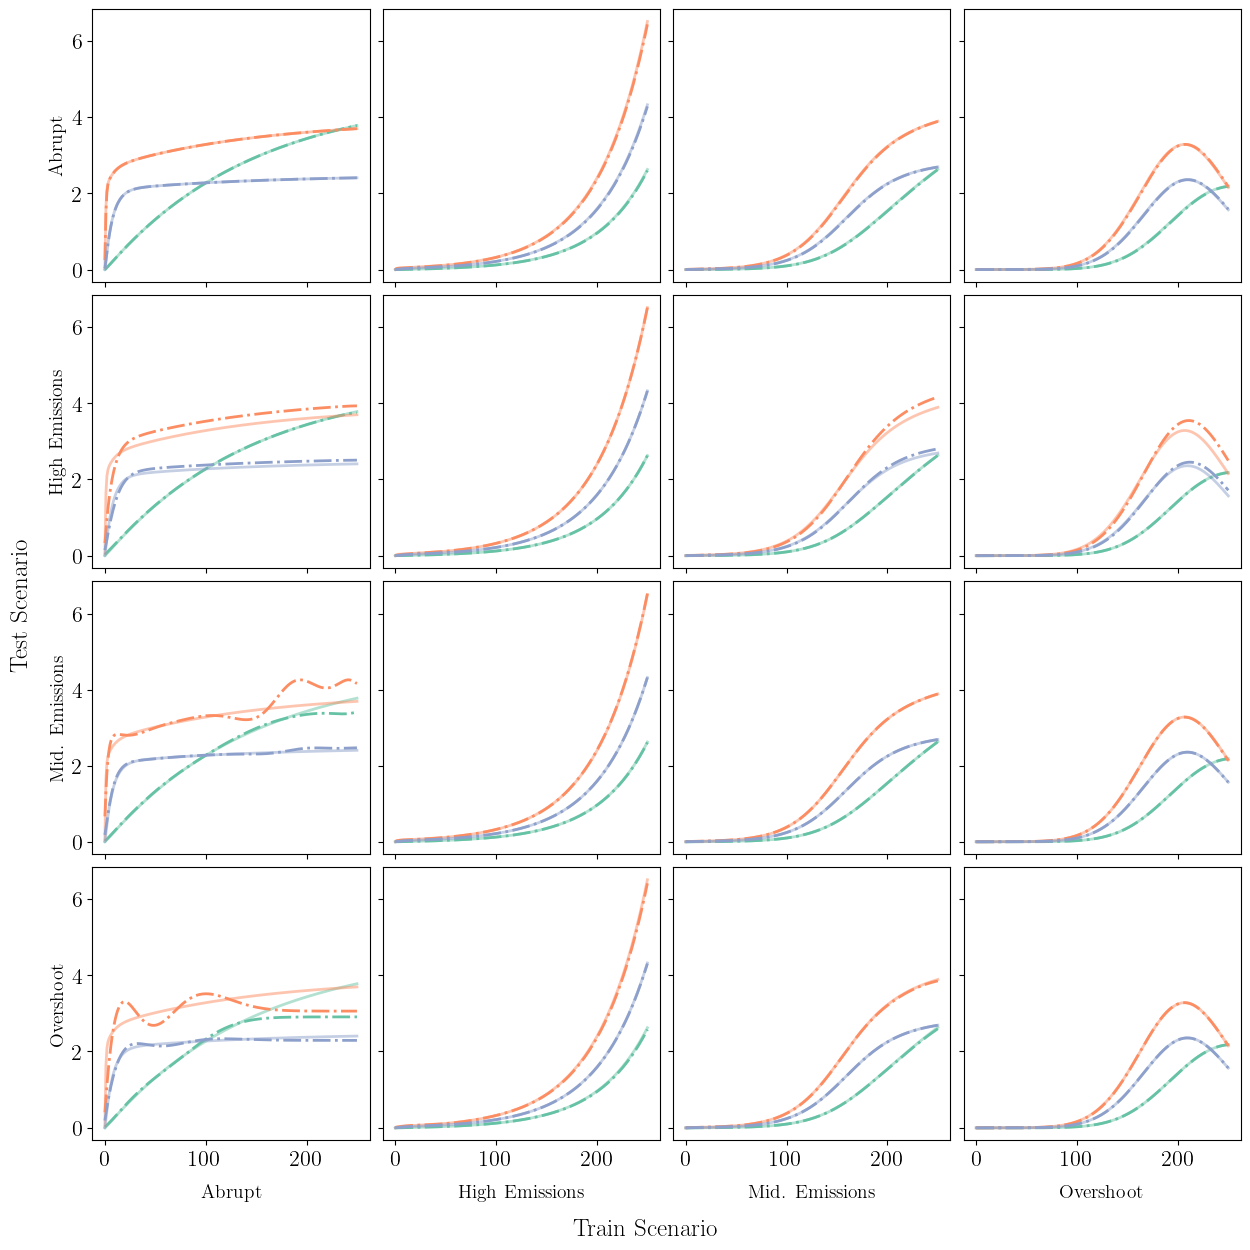

In [20]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_deconvolve, T_pred_deconvolve, error_metrics_deconvolve = emulator_utils.emulate_scenarios('deconvolve', scenarios=scenarios, outputs=T_out, forcings=forcings, dt=dt, regularize=True)
emulator_utils.plot_true_pred(T_out, T_pred_deconvolve, scenarios)
#emulator_utils.save_error(error_metrics_deconvolve, 'exp1_3_deconv_error')

<Axes: title={'center': 'Method 4: Deconvolution'}, xlabel='Train scenario', ylabel='Test scenario'>

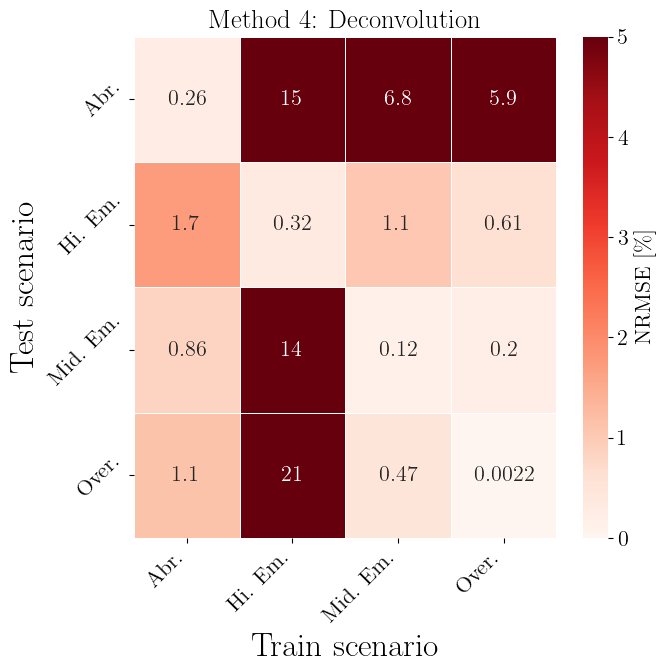

In [25]:
plot_error_heatmap(
    error_metrics   = error_metrics_deconvolve,
    exp             = "3box_coup",
    method          = "deconv",
    train_scenarios = scenarios,
    test_scenarios  = scenarios,
    vmax            = 5,
    save = False,
    long_title = 'Method 4: Deconvolution'
)

### Method 4: Exponential Fit

In [5]:
dt = 1
operator_fit, T_pred_fit, error_metrics_fit = emulator_utils.emulate_scenarios('fit_amp', scenarios=scenarios, outputs=T_out, forcings=forcings, t=t, dt=dt, n_boxes=n_boxes, n_modes=3, B=np.ones(n_boxes))
#emulator_utils.plot_true_pred(T_out, T_pred_fit, scenarios)
#emulator_utils.save_error(error_metrics_fit, 'exp1_4_fit_error')

Train: Abrupt - L2 Error
[  4.7615447 -13.721515  -12.566678   -6.028455    0.5519342 -10.654598
  -8.01522   -12.623155    2.56636    -4.9786983  -0.5315595  -2.098566 ]
	Test: Abrupt - [0.5377967  1.68661342 2.04147938]
	Test: High Emissions - [0.70778211 0.42163185 0.53512598]
	Test: Mid. Emissions - [0.51264508 1.0451288  0.46872943]
	Test: Overshoot - [0.6358754  1.44691638 1.15167484]
Train: High Emissions - L2 Error
[  5.0099053 -13.829879  -13.546732  -10.234516    1.2535075 -11.19875
 -11.184166  -13.199723    3.6821585  -6.919219   -1.2304647  -3.5853207]
	Test: Abrupt - [30.29055335 10.36492187 35.94885729]
	Test: High Emissions - [0.9268688 1.3026399 0.6569955]
	Test: Mid. Emissions - [ 6.67048389  3.38133977 27.84111181]
	Test: Overshoot - [ 8.12830774  5.48796893 41.09932372]
Train: Mid. Emissions - L2 Error
[  4.8257756 -13.805718  -13.536577   -6.633925    1.3362448 -11.217675
 -11.057173  -13.07963     2.735623   -5.2191544  -1.2368438  -2.308746 ]
	Test: Abrupt - [5.2

<Axes: title={'center': 'Method 5: Modal Fit'}, xlabel='Train scenario', ylabel='Test scenario'>

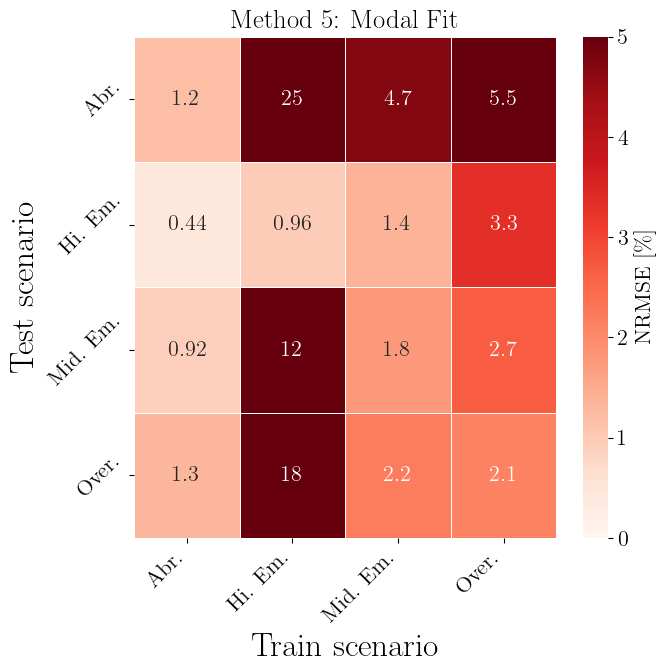

In [132]:
plot_error_heatmap(
    error_metrics   = error_metrics_fit,
    exp             = "3box_coup",
    method          = "fit",
    train_scenarios = scenarios,
    test_scenarios  = scenarios,
    vmax            = 5,
    save = False,
    long_title = 'Method 5: Modal Fit'
)

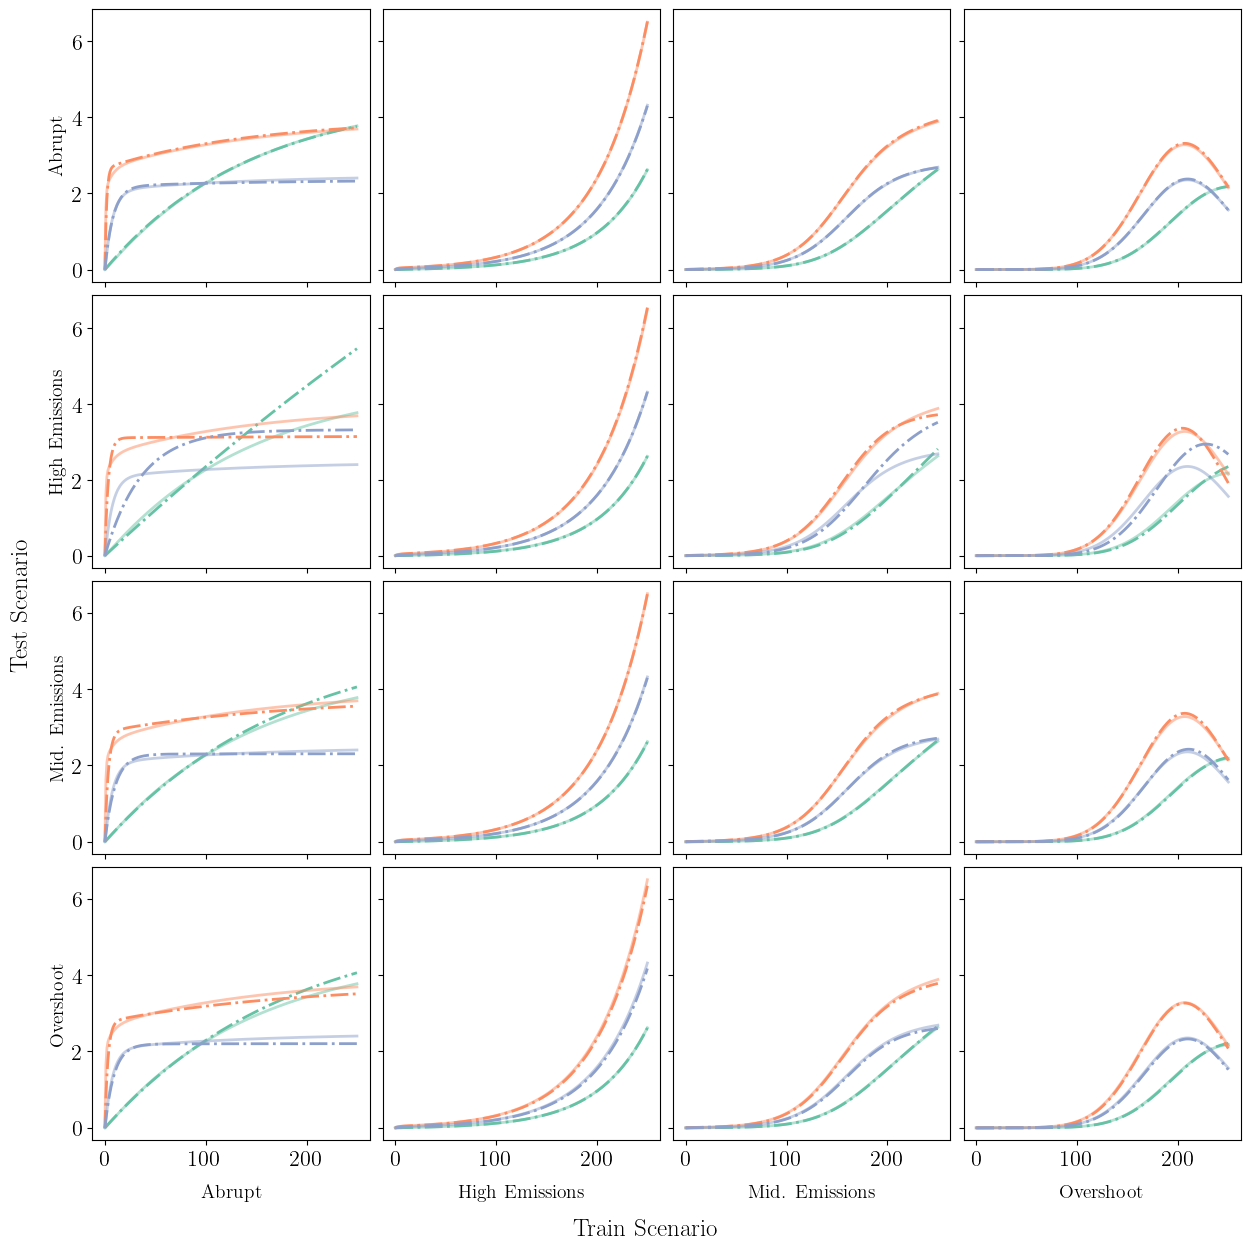

In [6]:
emulator_utils.plot_true_pred(T_out, T_pred_fit, scenarios)